<a href="https://colab.research.google.com/github/sujaykhandekar/Data-Mining-Business-Case/blob/master/shoeDetectorFastAITF_jit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fast.ai lesson 1 - training on Notebook Instance and export to torch.jit model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Overview
This notebook shows how to use the SageMaker Python SDK to train your fast.ai model on a SageMaker notebook instance then export it as a torch.jit model to be used for inference on AWS Lambda.

## Set up the environment

You will need a Jupyter notebook with the `boto3` and `fastai` libraries installed. You can do this with the command `pip install boto3 fastai`

This notebook was created and tested on a single ml.p3.2xlarge notebook instance. 


## Train your model

We are going to train a fast.ai model as per [Lesson 1 of the fast.ai MOOC course](https://course.fast.ai/videos/?lesson=1) locally on the SageMaker Notebook instance. We will then save the model weights and upload them to S3.



In [ ]:

!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:

!pip install "torch==1.4" "torchvision==0.5.0"

     |██████████████████▏             | 427.3MB 1.7MB/s eta 0:03:15ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import io
import tarfile

import PIL

import boto3

from fastai.vision import *

In [ ]:
root_dir = "drive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [ ]:

#!wget --no-check-certificate \
#        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

#local_zip = '//tmp/cats_and_dogs_filtered.zip'

#zip_ref = zipfile.ZipFile(local_zip, 'r')

#zip_ref.extractall('/tmp')
#zip_ref.close()

# Define our example directories and files
base_dir = 'drive/My Drive/Colab Notebooks/shoe detector'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_men_dir = os.path.join(train_dir, 'men_shoes') # Directory with our training cat pictures
train_women_dir = os.path.join(train_dir, 'women_shoes') # Directory with our training dog pictures
validation_men_dir = os.path.join(validation_dir, 'men_shoes_validation') # Directory with our validation cat pictures
validation_women_dir = os.path.join(validation_dir, 'women_shoes_validation')# Directory with our validation dog pictures

train_men_fnames = os.listdir(train_men_dir)
train_women_fnames = os.listdir(train_women_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 50,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 50,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1717 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#!wget --no-check-certificate \
 #   https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
 #   -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model=tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_shape=(150, 150, 3))

#pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
#                                include_top = False, 
#                                weights = None)

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:

from tensorflow.keras.optimizers import RMSprop
#building new model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    layers.Dropout(0.5),
    # 512 neuron hidden layer
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:






# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

#model = Model( pre_trained_model.input, x) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])



In [ ]:

len(train_generator)

14

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 34,
            epochs = 10,
            validation_steps = 13,
            verbose = 2,callbacks=[callback])

Epoch 1/10
34/34 - 117s - loss: 0.6170 - accuracy: 0.6677 - val_loss: 0.5916 - val_accuracy: 0.7015
Epoch 2/10
34/34 - 118s - loss: 0.6177 - accuracy: 0.6689 - val_loss: 0.6510 - val_accuracy: 0.6338
Epoch 3/10
34/34 - 117s - loss: 0.6105 - accuracy: 0.6755 - val_loss: 0.5648 - val_accuracy: 0.7308
Epoch 4/10
34/34 - 117s - loss: 0.6069 - accuracy: 0.6779 - val_loss: 0.5815 - val_accuracy: 0.7062
Epoch 5/10
34/34 - 117s - loss: 0.6023 - accuracy: 0.6671 - val_loss: 0.5601 - val_accuracy: 0.7231
Epoch 6/10
34/34 - 117s - loss: 0.5889 - accuracy: 0.6965 - val_loss: 0.6257 - val_accuracy: 0.6662
Epoch 7/10
34/34 - 119s - loss: 0.6007 - accuracy: 0.6815 - val_loss: 0.5504 - val_accuracy: 0.7123
Epoch 8/10
34/34 - 118s - loss: 0.5933 - accuracy: 0.6923 - val_loss: 0.5946 - val_accuracy: 0.6862
Epoch 9/10
34/34 - 118s - loss: 0.5882 - accuracy: 0.6935 - val_loss: 0.5407 - val_accuracy: 0.7292
Epoch 10/10
34/34 - 119s - loss: 0.5886 - accuracy: 0.6906 - val_loss: 0.5355 - val_accuracy: 0.7477

In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving US_01_132102_01.jpg to US_01_132102_01.jpg
US_01_132102_01.jpg
[[1.]]


In [ ]:
bs=64
path='drive/My Drive/Colab Notebooks/shoe detector'
#train='drive/My Drive/Colab Notebooks/shoe detector/train'
#valid='drive/My Drive/Colab Notebooks/shoe detector/validation'
#data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=150)
#transformed=get_transforms(do_flip=False, flip_vert=False, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
data = ImageDataBunch.from_folder(path,ds_tfms=get_transforms(),
                                   size=150, bs=bs//2).normalize(imagenet_stats)
#data = (ImageList.from_folder(path)
#                     .split_by_folder() 
#                     .label_from_folder()
#                     .databunch(path=path))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [ ]:
learn = cnn_learner(data, models.resnet101, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.164311,1.255898,0.675758,13:49
1,0.784782,0.640585,0.724242,00:57
2,0.564556,0.623113,0.742424,00:52
3,0.476232,0.578624,0.740909,00:51


Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

In [ ]:
learn.save('first_error')

In [ ]:

learn.show_results()

NameError: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

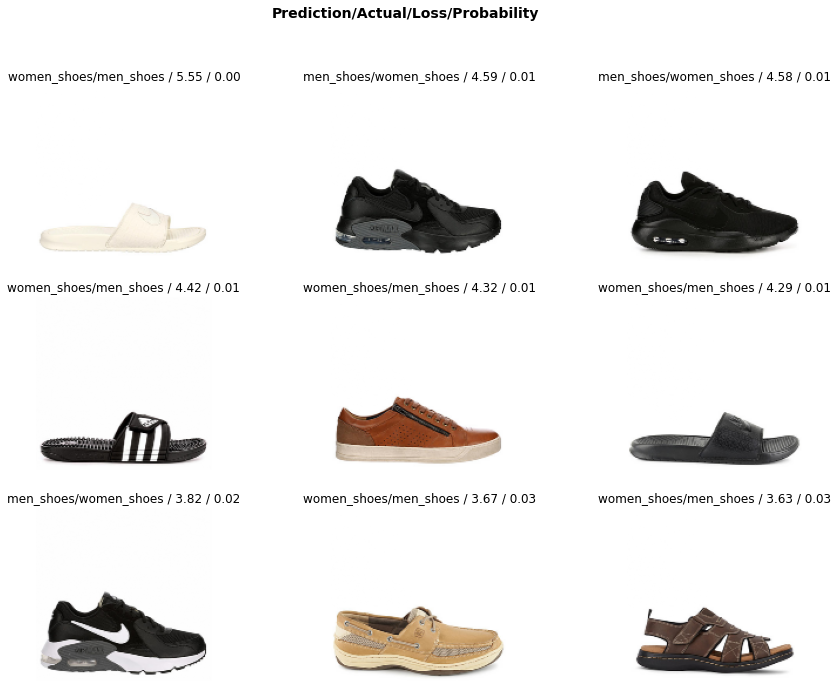

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

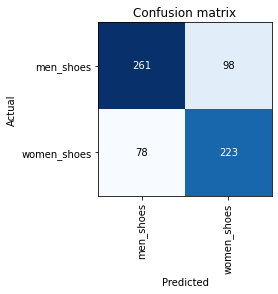

In [ ]:

interp.plot_confusion_matrix()

Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


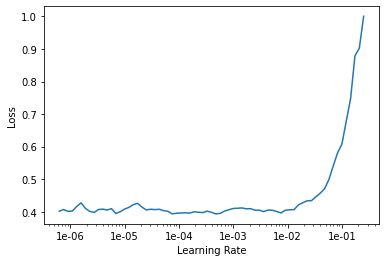

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.436888,0.542195,0.259091,07:50
1,0.406610,0.553321,0.268182,07:53


In [ ]:
path = untar_data(URLs.PETS); path

PosixPath('/content/data/oxford-iiit-pet')

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [ ]:
fnames = get_image_files(path_img)


In [ ]:
bs=64
img_size=150

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=img_size, bs=bs//2).normalize(imagenet_stats)
data

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
pug,leonberger,keeshond,miniature_pinscher,pomeranian
Path: /content/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
yorkshire_terrier,american_pit_bull_terrier,pomeranian,japanese_chin,samoyed
Path: /content/data/oxford-iiit-pet/images;

Test: None

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

## Export model and upload to S3

Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.


First we need to export the class names from the data object into a text file.

In [ ]:
save_texts(path_img/'models/classes.txt', data.classes)

Now we need to export the model in the [PyTorch TorchScript format](https://pytorch.org/docs/stable/jit.html) so we can load into an AWS Lambda function.

In [ ]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

Next step is to create a tarfile of the exported classes file and model weights.

In [ ]:
tar_file=path_img/'models/model.tar.gz'
classes_file='classes.txt'

In [ ]:
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

Now we need to upload the model tarball to S3.

In [ ]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'REPLACE_WITH_YOUR_BUCKET_NAME', 'fastai-models/lesson1/model.tar.gz')